<a href="https://colab.research.google.com/github/jakubhorvath/VariousMLNotebooks/blob/main/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Page Classification Notebook

In [ ]:
# Before you run this command create Kaggle account and download the API key for Kaggle
# Open your profile and download the token
# In Oliver's case https://www.kaggle.com/oliverchmelick/account
# Section API - revoke all old tokens and later create a new
# Once you download the token run this Colab window
# You will be prompted to enter the file. In your case the .json fle you have just downloaded


! pip install -q kaggle
from google.colab import files
files.upload()

! mkdir -p ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

MessageError: ignored

In [ ]:
! kaggle datasets download -d hetulmehta/website-classification
! unzip website-classification.zip
! rm website-classification.zip

## Load the data and display it

In [ ]:
import pandas as pd
data = pd.read_csv("/content/website_classification.csv")
data = data[["cleaned_website_text", "Category"]]
data.head()

FileNotFoundError: ignored

In [ ]:
data["Category"].value_counts()

# Convert the categorical "Category" into numerical classes

In [ ]:
import pandas as pd
data = pd.read_csv("/content/sample_data/website_classification.csv")

In [ ]:
data["Category"] = data["Category"].astype('category')
data["class"] = data["Category"].cat.codes
data["class"]

0       15
1       15
2       15
3       15
4       15
        ..
1403     0
1404     0
1405     0
1406     0
1407     0
Name: class, Length: 1408, dtype: int8

# Important word analysis
- Select top n words with the highest impact on the category
- Using **sklearn.feature_extraction.text.TfidfVectorizer**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
TFV = TfidfVectorizer(max_df=0.8, max_features=1000)
X = TFV.fit_transform(data["cleaned_website_text"])

In [ ]:
columns = TFV.get_feature_names_out()

corr_data = pd.DataFrame(X.todense())
corr_data.set_axis(columns, axis=1, inplace=True)
corr_data["class"] = data["class"]
class_correlation = corr_data.corr()["class"]
dictionary = class_correlation.to_dict()


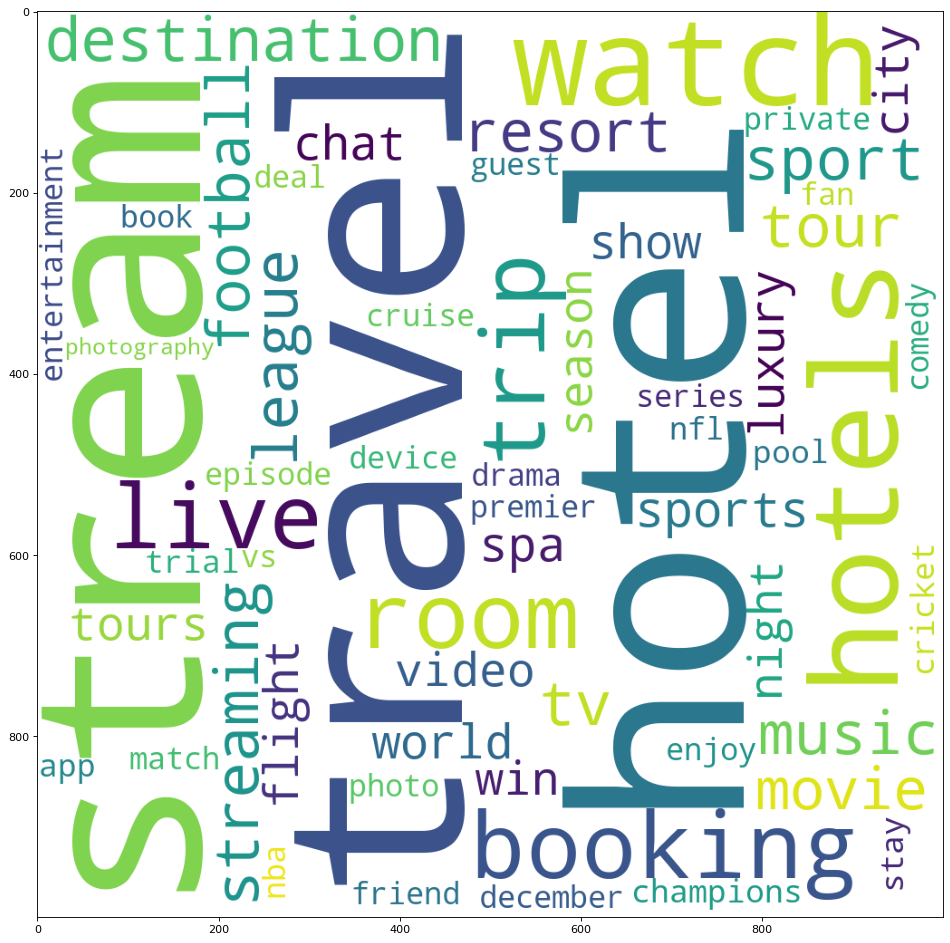

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize=(15, 15), dpi=80)
del dictionary["class"]
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=60,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dictionary)
plt.imshow(wc)

# Visualize using PCA

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Text(0.5, 1.0, 'PCA on the dataset')

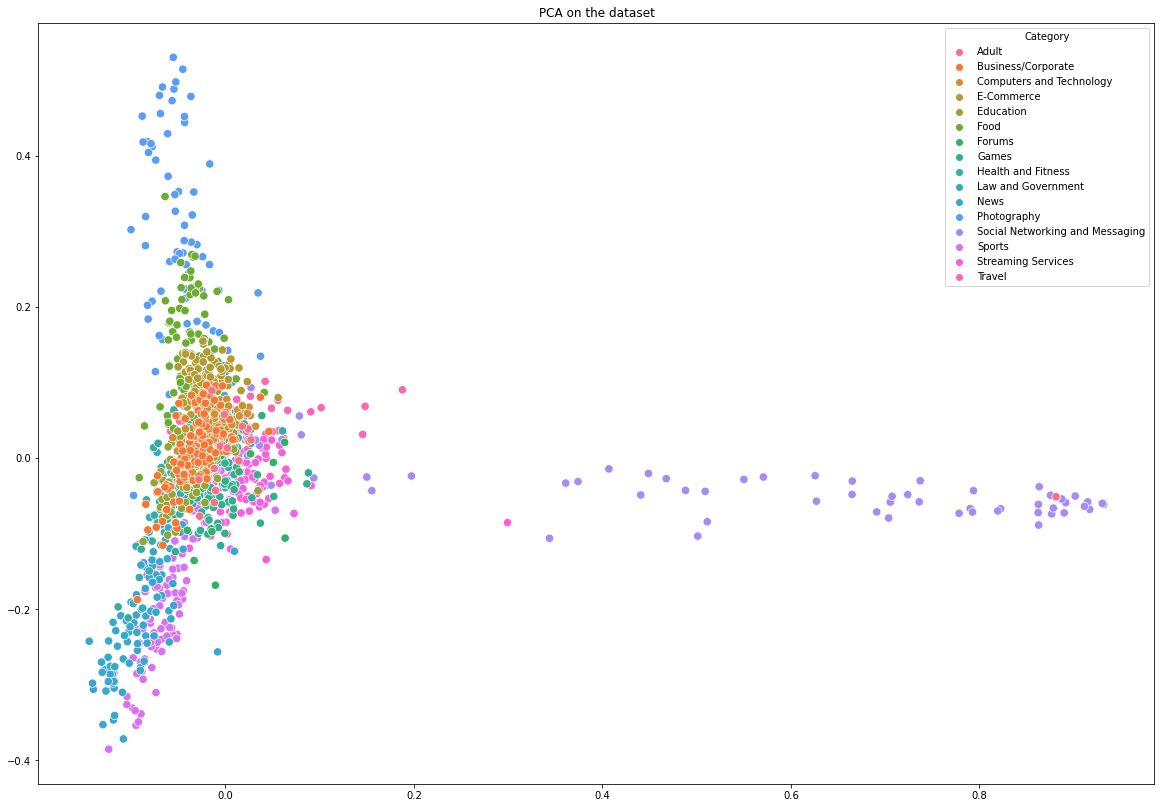

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

import matplotlib.pyplot as plt

# create and fit the PCA
pca = PCA(n_components=2)
sc = pca.fit_transform(X.todense());


# plot the data
fig, ax = plt.subplots(figsize=(20, 14))
cmap = sns.color_palette("tab10",as_cmap=True)
plot= sns.scatterplot(x=[x[0] for x in sc],y=[x[1] for x in sc],hue=data["Category"], cmap=cmap, s=70);
plot.set_title('PCA on the dataset')

# Run grid-search to detect the optimal hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline([("vectorizer",TfidfVectorizer()),
                 ("classifier", MultinomialNB())])
parameters = {
	'vectorizer__max_df' : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
  'vectorizer__max_features' : [100, 500, 1000, 1500, 2000],
	'classifier__alpha' : [0.1, 0.4, 0.7, 1],
  'classifier__fit_prior' : [True, False]
}

X_train, X_test, y_train, y_test = train_test_split(data["cleaned_website_text"], data["class"], random_state=42, test_size=0.3)

grid = GridSearchCV(pipe, parameters, verbose=3).fit(X_train, y_train)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(data["cleaned_website_text"], data["class"], random_state=42, test_size=0.3)
grid = Pipeline([("vectorizer",TfidfVectorizer(max_df=0.5, max_features=1000)),
                 ("classifier", MultinomialNB(alpha=0.4, fit_prior=False))])

grid.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.5, max_features=1000)),
                ('classifier', MultinomialNB(alpha=0.4, fit_prior=False))])

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print("Accuracy on test set: ",grid.score(X_test, y_test))

NameError: ignored

# Analyze the training resuls

In [ ]:
import numpy as np
cmap = sns.cm.rocket_r
fig, a = plt.subplots(figsize=(20, 14))
ax = sns.heatmap(pd.crosstab(y_train, grid.predict(X_train)), cmap=cmap ,xticklabels=dict( enumerate(data['Category'].cat.categories )).values(), yticklabels=dict( enumerate(data['Category'].cat.categories )).values(), annot=True)
ax.set(xlabel='predicted', ylabel='actual')

[Text(159.0, 0.5, 'actual'), Text(0.5, 105.0, 'predicted')]

[Text(147.49999999999997, 0.5, 'actual'), Text(0.5, 93.5, 'predicted')]

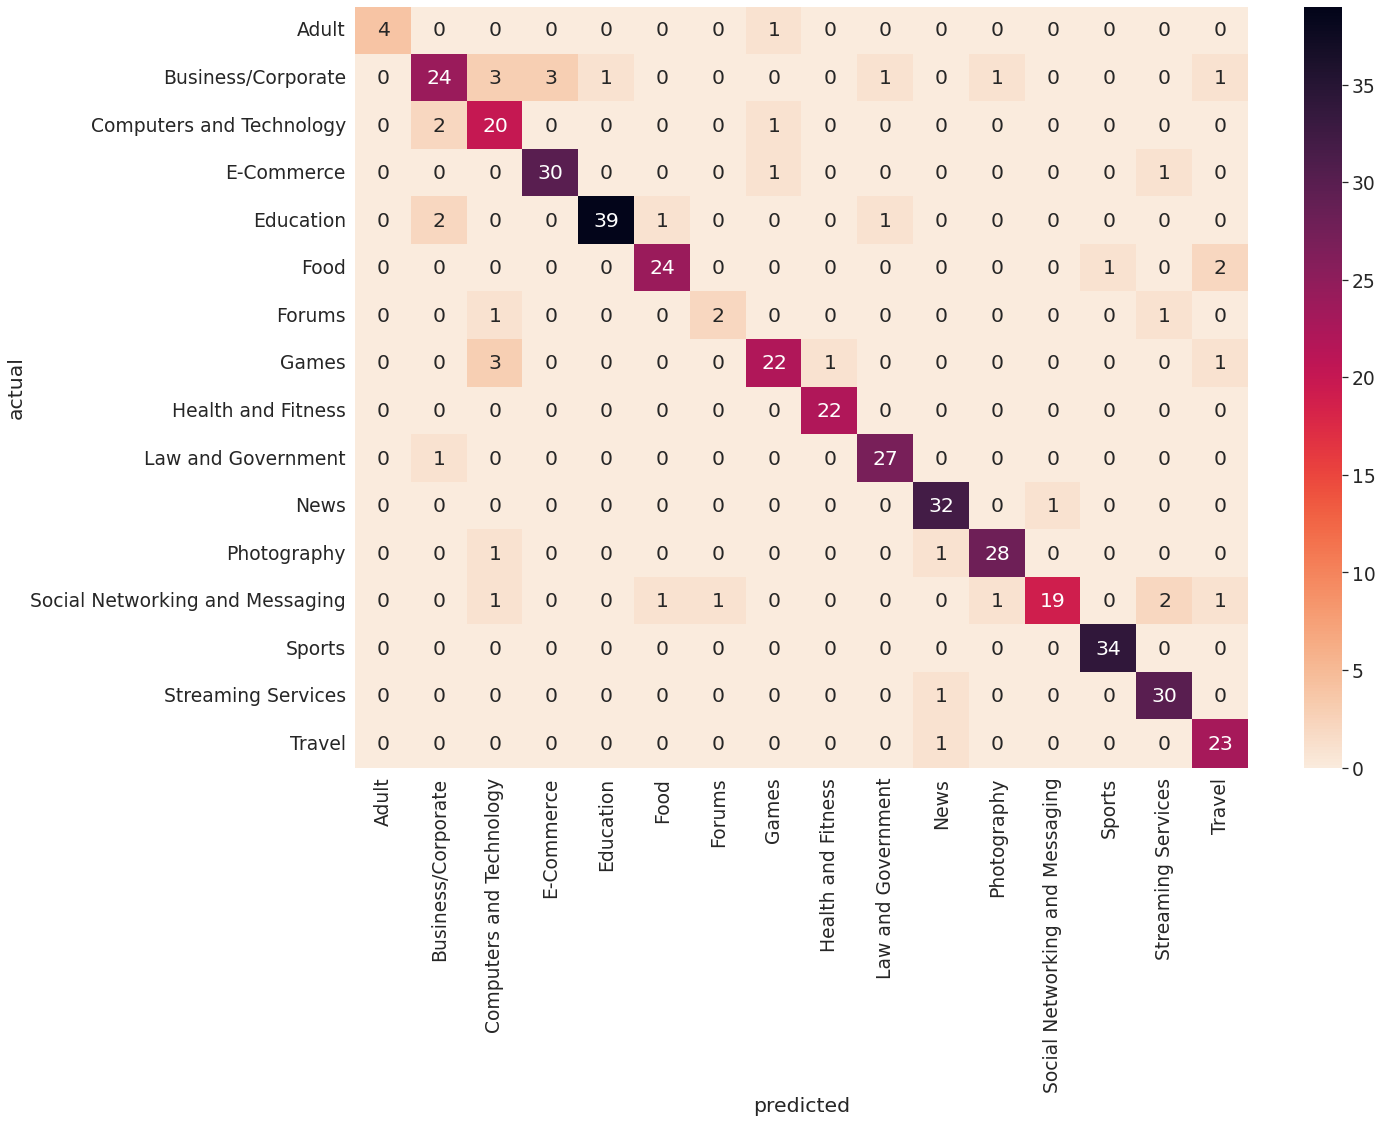

In [ ]:
sns.set(font_scale=1.4)
cmap = sns.cm.rocket_r
fig, a = plt.subplots(figsize=(20, 14))
ax = sns.heatmap(pd.crosstab(y_test, grid.predict(X_test)), cmap=cmap, xticklabels=dict( enumerate(data['Category'].cat.categories )).values(), yticklabels=dict( enumerate(data['Category'].cat.categories )).values(), annot=True)
ax.set(xlabel='predicted', ylabel='actual')